In [2]:
%matplotlib inline
import matplotlib.pyplot as pp
import numpy as np
from scipy import signal
import librosa
import librosa.display
from IPython import display
from copy import deepcopy

# the pra library
import pyroomacoustics as pra

In [3]:
# A simple wrapper class for (1-channel) audio data
# data is a 1-D NumPy array containing the data
# rate is a number expressing the samples per second
class Audio:
    def __init__(self, data, rate):
        self.data = data
        self.rate = rate
    def play(self):
        return display.Audio(self.data, rate=self.rate)
    def plot_wave(self):
        librosa.display.waveplot(self.data, sr=self.rate)
    def plot_spectrum(self):
        n_fft = int(self.rate / 20)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(self.data, n_fft)), ref=np.max)
        librosa.display.specshow(D, y_axis='linear', sr=self.rate, hop_length=n_fft/4)
    @classmethod
    def fromfile(cls, fn):
        return cls(*librosa.load(fn, sr=None))

In [4]:
hello = Audio.fromfile("hello.wav")
print(hello.rate)
print(len(hello.data))
hello.play()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


44100
252864


In [5]:
byebye = Audio.fromfile("byebye.wav")
print(byebye.rate)
print(len(byebye.data))

44100
287680


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [6]:
# cut byebye to same length as hello
byebye_new = byebye.data[:len(hello.data)]
byebye = Audio(byebye_new, hello.rate)
print(byebye.rate)
print(len(byebye.data))
byebye.play()

44100
252864


## Beamforming

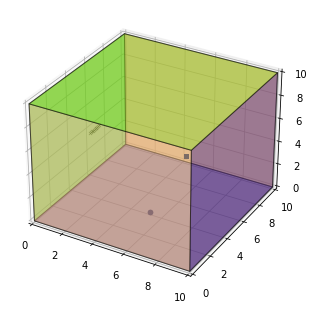

In [147]:
'''Room Parameters and Room Creation'''
room_dim = [10, 10, 10] # meters
m = pra.Material(energy_absorption="panel_fabric_covered_6pcf")
room = pra.ShoeBox(room_dim, fs=hello.rate, materials=m, max_order=0) #simulate perfect situation: no reflections

'''Sound Source Creation'''
room.add_source([7, 1, 3], signal=hello.data)
room.add_source([7, 5, 5], signal=byebye.data[:len(hello.data)])
# room.add_source([7, 9, 8], signal=reverse_sweep, delay=1) # inference 2?

'''Mic Array Creation'''
mic_locs = np.c_[
    [1, 4.5, 5],
    [1, 4.6, 5],
    [1, 4.7, 5],
    [1, 4.8, 5],
    [1, 4.9, 5],
    [1, 5, 5],
    [1, 5.1, 5],
    [1, 5.2, 5],
    [1, 5.3, 5],
    [1, 5.4, 5],
    [1, 5.5, 5]
]

# mic_locs = np.c_[
#     [1, 5, 5],
#     [1, 5.1, 5],
#     [1, 5, 5.1],
#     [1, 5.1, 5.1]
# ]

# # center of array as column vector
# mic_center = np.c_[[1, 5, 5]]
# # microphone array radius
# mic_radius = 0.05
# # number of elements
# mic_n = 8
# # The GridSphere objects creates a number of points
# # pseudo-uniformly spread on the unit sphere
# grid = pra.doa.GridSphere(mic_n)
# # The locations of the microphones can then be computed
# mic_locs = mic_center + mic_radius * grid.cartesian

# filter size (???)
Lg_t = 0.1 # filter size in seconds
Lg = np.ceil(Lg_t*room.fs)


# place the beamforming micarray in the room (the beamforming class is a child class of the micarray class)
fft_len = 512
mics = pra.Beamformer(mic_locs, room.fs, N=fft_len, Lg=Lg)
room.add_microphone_array(mics)


# Compute DAS (delay and sum) weights
mics.rake_delay_and_sum_weights(room.sources[0])

'''Simulation'''
room.compute_rir()
room.simulate()


fig, ax = room.plot()

In [148]:
### Original_mixed ###
original_signal = room.mic_array.signals[0, :]
mix_audio = Audio(original_signal, room.fs)
mix_audio.play()

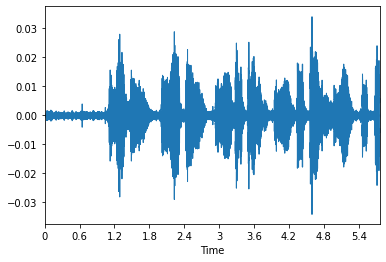

In [149]:
mix_audio.plot_wave()

In [150]:
### Beamformed ###
resulted_signal = mics.process()
bf_audio = Audio(resulted_signal, room.fs)
bf_audio.play()

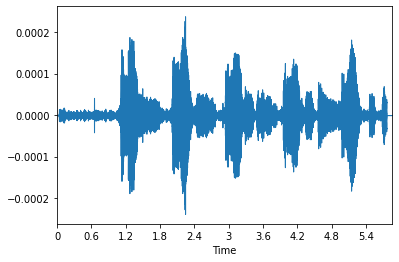

In [151]:
bf_audio.plot_wave()

In [152]:
original_byebye_seg = byebye.data[int(1.5 * byebye.rate):int(1.9 * byebye.rate)]
original_byebye_seg_audio = Audio(original_byebye_seg, byebye.rate)
original_byebye_seg_audio.play()

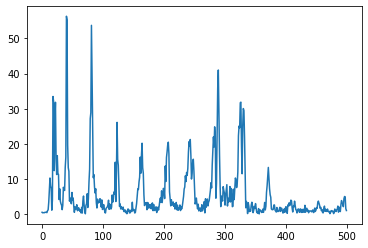

In [153]:
pp.plot(np.abs(np.fft.rfft(original_byebye_seg)[:500]))

In [154]:
bf_byebye_seg = bf_audio.data[int(1.5 * byebye.rate):int(1.9 * byebye.rate)]
bf_byebye = Audio(bf_byebye_seg, bf_audio.rate)
bf_byebye.play()

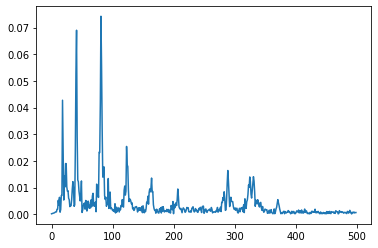

In [155]:
pp.plot(np.abs(np.fft.rfft(bf_byebye_seg)[:500]))

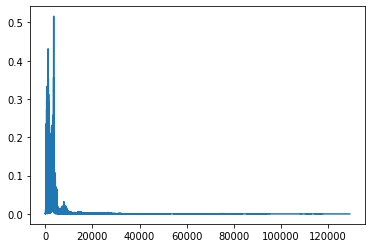

In [156]:
bf_fft = np.fft.rfft(bf_audio.data)
pp.plot(np.abs(bf_fft))

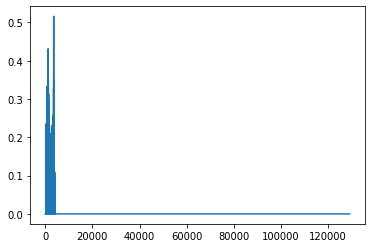

In [157]:
bf_fft_denoised = bf_fft[:]
bf_fft_denoised[np.abs(bf_fft_denoised) < 0.1] = 0
pp.plot(np.abs(bf_fft_denoised))

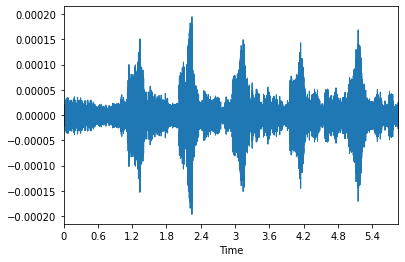

In [158]:
bf_denoised_audio = Audio(np.fft.irfft(bf_fft_denoised), bf_audio.rate)
bf_denoised_audio.plot_wave()
bf_denoised_audio.play()